In [1]:
#default_exp utils

In [2]:
#export
from fastai.vision.all import *

In [3]:
#export
import PIL
from typing import List
from torchvision.utils import make_grid

### Utility Functions

In [4]:
#export
def open_image(fname:Union[str,Path], size:tuple=None, as_array=False, as_tensor=False):
    'Open a _single_ image from disk, optionally resize and/or convert to array'
    img = PIL.Image.open(fname).convert('RGB')
    if isinstance(size, float): size = L(img.size).map(lambda x: int(x*size))
    if size is not None: img = img.resize(size)
    if as_array or as_tensor: return img2arraylike(img, as_array, as_tensor)
    return img

def img2arraylike(img:PIL.Image.Image, as_array=False, as_tensor=True):
    img = np.array(img).transpose(2,0,1)
    if as_array: return img
    if as_tensor: return torch.from_numpy(img)

### Make Image Grid

In [5]:
#export
def make_img_grid(images : Union[List[str], List[PILImage], List[PIL.Image.Image]],
                  img_size : Union[tuple, float, None] = (480,270),
                  ncol : int=8
                  ) -> PIL.Image.Image:
    """Make a grid of images from `images` with `ncol` columns.
    
    `images` can be a list of filenames or a list of PIL Images,
             which will be resized to `img_size`
    `img_size` must be used unless all images are of the same size
    """
    if not isinstance(images, (list,L)): raise TypeError(f"Expected a list of (paths,PILImage,PIL.Image.Image) objects, got {type(images)} instead")
    if isinstance(images[0], (str,Path)):
        img_list = [open_image(f, as_tensor=True, size=img_size) for f in images]
    if isinstance(images[0], (PILImage, PIL.Image.Image)):
        img_list = images
        if img_size is not None:
            img_list = [img.resize((img_size)) for img in img_list]
        img_list = [img2arraylike(img) for img in img_list]
    grid_array = make_grid(img_list, nrow=ncol)
    grid_array = grid_array.numpy().transpose((1,2,0))
    return PIL.Image.fromarray(grid_array)

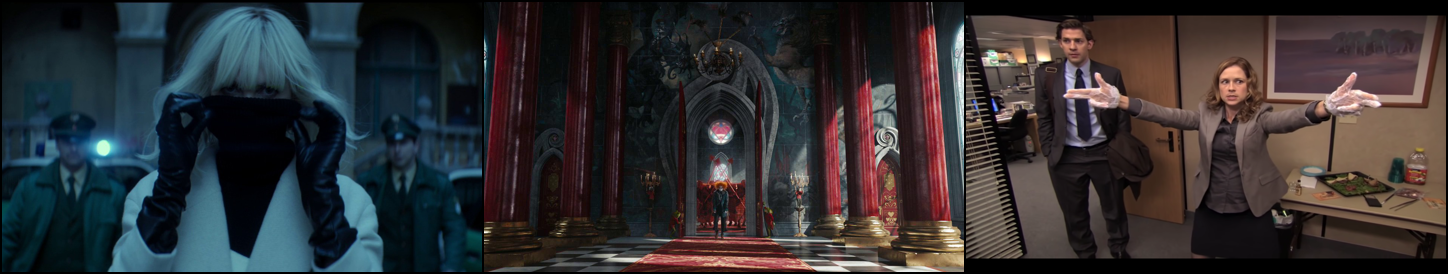

In [6]:
path = "../assets/imgs/"

files = get_image_files(path)
make_img_grid(files)

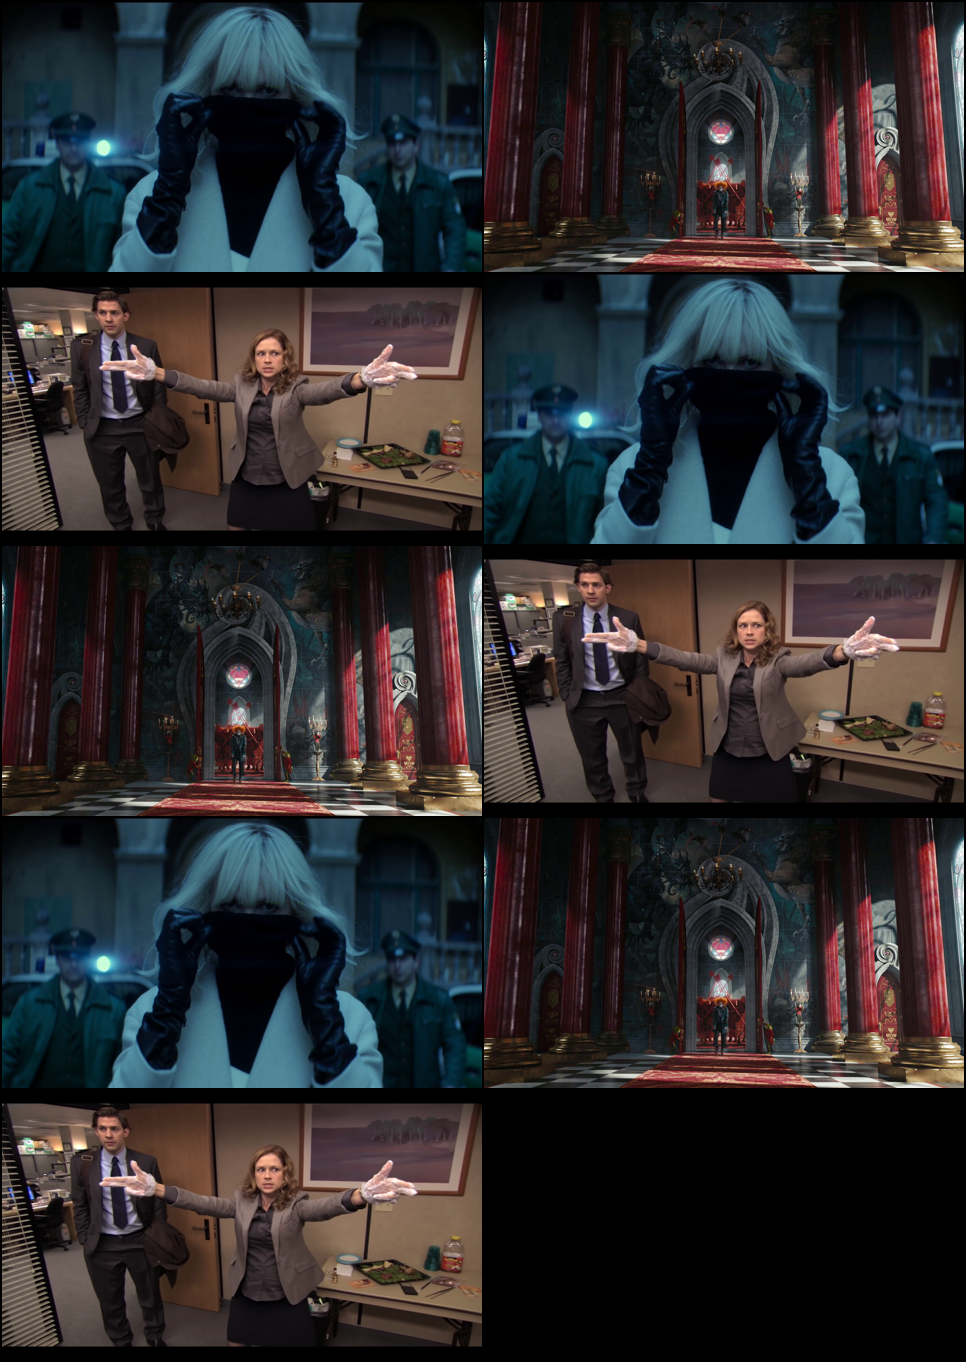

In [7]:
make_img_grid(files * 3, ncol=2)

### PIL Image Draw

In [8]:
#export
import PIL
from fastai.vision.all import *
from PIL import ImageDraw, ImageFont

In [26]:
#export
color = lambda r,g,b: f'rgb({r},{g},{b})'

@patch
def draw_labels(
    self:PIL.Image.Image,
    labels:list,
    font_size:float=None,
    font_color:Union[tuple,int] = (220,220,220),
    #font_path:str  = '../fonts/DIN Alternate Bold.ttf',
    font_path:Optional[str]  = None,
    location:str   = 'bottom',
    draw_rect:bool = False,
    fsize_div_factor:int = 32
    ) -> PIL.Image.Image:
    """Draw `labels` on top of `img`
    
    * labels: The text that will be "drawn" on the image. Can be a
              list of strings as well
    * font_size: Explicitly set font-size. Not recommended.
                 See `fsize_div_factor` to scale font size proportionately
    * font_color: An int or tuple of RGB color values
    * font_path: Path to the font file (tested with `.ttf`)
    * location: Where to draw the text? Any combination of
                {bottom,top} + {right,left} where {bottom,top}
                are mandatory
    * draw_rect: Draw a black rectangle behind the text for clarity
    * fsize_div_factor: Set font size to img.width/fsize_div_factor
                        Font size is smaller for larger values
    """
    if font_path is not None:
        # PIL gives an unintuitive OSError without much useful info
        if not Path(font_path).exists: raise FileNotFoundError(f"Couldn't find font file @ {font_path}")
    if font_path is not None:
        font = ImageFont.truetype(font_path, size=font_size)
    else:
        if font_size is not None:
            raise RuntimeError(f"`font_size` cannot be set when not using a custom font passed via `font_path`")
        else:
            font = ImageFont.load_default()
            warnings.warn("Loaded default PIL ImageFont. It's highly recommended you use a custom font as the default font's size cannot be tweaked")
    img = self # this allows us to easily pull out the function without `@patch` support
    draw = ImageDraw.Draw(img)
    if font_size is None: font_size = int(img.width/fsize_div_factor)
    
    fcolor = color(*font_color)
    # Check for valid locations
    valid_locations = ['bottom', 'bottom-right', 'bottom-left',
                       'top', 'top-right', 'top-left']
    if not location in valid_locations: raise ValueError(f"`location` must contain 'bottom' or 'top', got {location}")
    
    # Convert labels to drawable format
    if isinstance(labels, str): labels = [labels]
    if 'top' in location: labels = ['\n'.join(labels)]
    
    # Draw rectangle if asked for
    if draw_rect:
        #rect_x, rect_y
        if 'bottom' in location:
            rect_x = (0,img.height-(1.1*len(labels)*font_size*1.25))
            rect_y = (img.width,img.height)
        if 'top' in location:
            rect_x = (img.width,0)
            rect_y = (0, 1.1*len(labels)*font_size*1.25)
        draw.rectangle(xy=(rect_x, rect_y), fill='black')
    
    for i,label in enumerate(list(reversed(labels))):
        if 'bottom' in location or 'top' in location:
            w,h = draw.textsize(label, font)
            
        if 'bottom' in location:
            height = img.height-((i+1)*font_size*1.3)
        
        elif 'top' in location:
            height = img.height*0.01
        
        if location=='bottom' or location=='top': xy = ( (img.width - w)/2, height)            
        elif '-right' in location: xy = ( ((img.width - (w+img.width*0.01))), height )
        elif '-left' in location:  xy = ( img.width*0.01 , height )
        else:
            if i==0: y=1
            else:    y=(i*font_size*1.5)
            xy = (10,y) 

        # thin border
        x,y = xy[0],xy[1]
        draw.text((x-1, y), label, font=font, fill='black')
        draw.text((x+1, y), label, font=font, fill='black')
        draw.text((x, y-1), label, font=font, fill='black')
        draw.text((x, y+1), label, font=font, fill='black')

        # thicker border
        draw.text((x-1, y-1), label, font=font, fill='black')
        draw.text((x+1, y-1), label, font=font, fill='black')
        draw.text((x-1, y+1), label, font=font, fill='black')
        draw.text((x+1, y+1), label, font=font, fill='black')
        
        draw.text(xy, text=label, fill=fcolor, font=font)
    return img

In [27]:
from nbdev.showdoc import *
show_doc(PIL.Image.Image.draw_labels)

<h4 id="Image.draw_labels" class="doc_header"><code>Image.draw_labels</code><a href="__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>Image.draw_labels</code>(**`labels`**:`list`, **`font_size`**:`float`=*`None`*, **`font_color`**:`Union`\[`tuple`, `int`\]=*`(220, 220, 220)`*, **`font_path`**:`Optional`\[`str`\]=*`None`*, **`location`**:`str`=*`'bottom'`*, **`draw_rect`**:`bool`=*`False`*, **`fsize_div_factor`**:`int`=*`32`*)

```
Draw `labels` on top of `img`

* labels: The text that will be "drawn" on the image. Can be a
          list of strings as well
* font_size: Explicitly set font-size. Not recommended.
             See `fsize_div_factor` to scale font size proportionately
* font_color: An int or tuple of RGB color values
* font_path: Path to the font file (tested with `.ttf`)
* location: Where to draw the text? Any combination of
            {bottom,top} + {right,left} where {bottom,top}
            are mandatory
* draw_rect: Draw a black rectangle behind the text for clarity
* fsize_div_factor: Set font size to img.width/fsize_div_factor
                    Font size is smaller for larger values
```

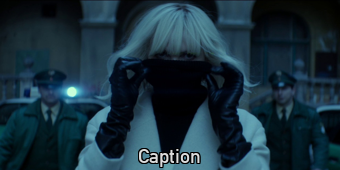

In [28]:
img = PIL.Image.open("../assets/imgs/atomic-blonde.jpg").resize((340,170))
img.draw_labels('Caption', location='bottom', font_size=20, font_path="../fonts/DIN Alternate Bold.ttf")

/home/synopsis/miniconda3/envs/torch17/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Loaded default PIL ImageFont. It's highly recommended you use a custom font as the default font's size cannot be tweaked


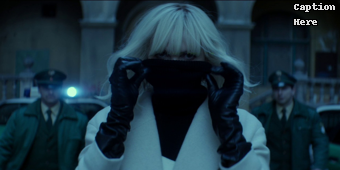

In [30]:
img = PIL.Image.open("../assets/imgs/atomic-blonde.jpg").resize((340,170))
img.draw_labels(['Caption', 'Here'], location='top-right')

### Export

In [31]:
#hide
from nbdev.export import *
notebook2script('utils.ipynb')

Converted utils.ipynb.
